## XModalix Port First Milestone: ImageVAE + Loader


### Outcome
- Have a image loader and image VAE
- Train this in a notebook
    - With c. elegans and MNIST images


### Checks
- Check loss curves
- Check image recons
- 


### Steps
- Prepare datasets
    - Maybe already done in 00 notebook
- Prepare config
- Write ImageDataset Class
- Write / port ImageVAE

#### IMPORTS

In [1]:
import os
from autoencodix.utils.default_config import DataConfig, DataInfo, DefaultConfig
import autoencodix as acx

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
print(notebook_dir)
os.chdir(notebook_dir)
os.chdir("..")
print(os.getcwd())


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/maximilianjoas/development/autoencodix_package/notebooks
/Users/maximilianjoas/development/autoencodix_package


#### GLOBALS


In [2]:
IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

In [3]:
img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
                translate_direction="to",
            ),
            "RNA": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        }
    )
)

In [4]:
xmodalix = acx.XModalix(config=img_config)
xmodalix.preprocess()

Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='STANDARD' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction='to'
Checking data type: RNA
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt
 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'multi_bulk': 0}, 'annotation': {'from': 260}, 'img': {'img': 0}, 'from_modality': {'RNA': 260}, 'to_modality': {'IMG': 260}, 'paired_count': {'paired_count': 260}}
key: train, type: <class 'dict'>
key: valid, type: <class 'dict'>
key: test, type: <class 'dict'>


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_nanremover.py:196: UserWarning: Skipping unknown type in to_modality.IMG: <class 'list'>
  warnings.warn(


In [20]:
import matplotlib.pyplot as plt

images = xmodalix._preprocessor.dataset_dicts["train"]["data"].to_modality["IMG"]
sample_image = images[0]
type(images)

list

In [6]:
from torch.utils.data import DataLoader, Dataset

In [23]:
import torch
from autoencodix.utils.default_config import DefaultConfig
from autoencodix.base._base_dataset import BaseDataset
from typing import List, Tuple, Union
from autoencodix.data._imgdataclass import ImgData


class ImageDataset(BaseDataset):
    def __init__(self, data: List[ImgData], config: DefaultConfig):
        self.data = data
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return idx, torch.tensor(self.data[idx].img), self.data[idx].sample_id

    def get_input_dim(self) -> Tuple[int, int, int]:
        """Gets the input dimension of the dataset's feature space.

        Returns:
            The input dimension of the dataset's feature space.
        """
        return self.data[0].img.shape  # Assuming all images have the same shape


In [8]:
imgloader = DataLoader(
    ImageDataset(data=images, config=xmodalix.config),
    batch_size=32,
    shuffle=True,
)

Batch index: tensor([ 71, 127, 174, 117,  38, 115,  63, 170,  33,  91,  29, 159, 110, 143,
        162,  30, 175, 124, 177, 176,  87, 133, 180,  56, 151, 139,  85,   1,
         62, 130,  69,  40])
Image shape: torch.Size([32, 1, 64, 64])
Sample IDs: ('T_237', 'T_200', 'T_34', 'T_164', 'T_129', 'T_98', 'T_210', 'T_184', 'T_24', 'T_141', 'T_109', 'T_63', 'T_196', 'T_4', 'T_113', 'T_110', 'T_48', 'T_91', 'T_235', 'T_182', 'T_153', 'T_47', 'T_36', 'T_25', 'T_148', 'T_190', 'T_159', 'T_167', 'T_188', 'T_161', 'T_20', 'T_138')


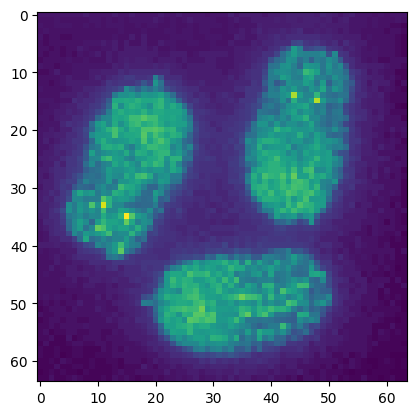

In [9]:
for idx, img, sample_ids in imgloader:
    print(f"Batch index: {idx}")
    print(f"Image shape: {img.shape}")
    print(f"Sample IDs: {sample_ids}")
    plt.imshow(img[0].squeeze())
    plt.show()
    break  # Remove this line to iterate through the entire DataLoader

In [24]:
from autoencodix.modeling._imagevae_architecture import ImageVAEArchitecture

In [25]:
from autoencodix.trainers._general_trainer import GeneralTrainer
from autoencodix.utils._losses import VarixLoss
from autoencodix.utils._result import Result

trainset = ImageDataset(data=images, config=xmodalix.config)
valid_images = xmodalix._preprocessor.dataset_dicts["valid"]["data"].to_modality["IMG"]
validset = ImageDataset(data=valid_images, config=xmodalix.config)
trainer = GeneralTrainer(
    trainset=trainset,
    validset=validset,
    model_type=ImageVAEArchitecture,
    config=xmodalix.config,
    result=Result(),
    loss_type=VarixLoss,
)

AttributeError: 'list' object has no attribute 'shape'

In [17]:
from typing import cast
cast(BaseDataset, trainset).get_input_dim()

1

In [19]:

trainset.data[0].img.shape

(1, 64, 64)